
# Smart Grid: Combining Cost Optimisation and Flexibility Scoring

This notebook explores simulated household electricity usage under dynamic pricing schemes to: 
- Identify flexibility opportunities
- Compare Agile vs Flat rates
- Prototype cost optimisation model

We choose to focus on two complementary modelling directions:

## 1. Cost Optimisation:
We explore how households can reduce their electricity bills by **shifting usage away from high-price periods** under Agile pricing. This includes a rule-based approach to avoid peak rates, and a capped flexibility model that simulates practical limits to behaviour change.

## 2. Flexibility Opportunity Scoring:
We evaluate households' alignment with **flexibility events** (e.g. turn-down and turn-up incentives) to simulate how much financial reward each type could earn through participation in smart grid programs.

---

### Why Combine These Two?
These models answer two sides of the same energy management question:

- **Cost Optimisation** helps households save money *internally* by automating when they use power.
- **Flexibility Scoring** helps utilities and platforms like Komodo reward *external responsiveness* to system signals.

Together, they demonstrate how household behaviour can be influenced both **proactively (cost saving)** and **reactively (event reward)** and also highlight who benefits most from which approach.

This combined view allows us to explore the full product opportunity for a smart grid management tool that serves **both consumer value and grid value**.

---

## 1. Load and Preprocess Data

### Load and Clean Household Usage Data

- Loads the household usage data from `household_usage.csv`, cleans it by removing unnecessary columns, melts it into a long format, and converts the time column into a datetime format.
- It then saves the cleaned data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load raw CSV
df_raw = pd.read_csv("household_usage.csv")

# Drop unnamed empty columns
df_clean = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed")].copy()

# Melt the data to long format for ease of use later
df_long = df_clean.melt(id_vars=["Time"], var_name="household_type", value_name="usage_kwh")

# Convert time to datetime using a fixed dummy date
df_long["datetime"] = pd.to_datetime("2025-03-13 " + df_long["Time"])
df_long.drop(columns=["Time"], inplace=True)

# Save cleaned version for dashboard use
df_long.to_csv("household_usage_cleaned.csv", index=False)

df_long.head()

,household_type,usage_kwh,datetime
0,Standard_Household,0.4,2025-03-13 00:00:00
1,Standard_Household,0.3,2025-03-13 00:30:00
2,Standard_Household,0.3,2025-03-13 01:00:00
3,Standard_Household,0.3,2025-03-13 01:30:00
4,Standard_Household,0.2,2025-03-13 02:00:00


---

## 2. Merge Agile Pricing with Usage Data

### Load Agile Pricing and Merge with Usage Data

- Loads the agile pricing data from a JSON file, converts it into a dataframe, and merges it with the household usage data on the datetime column.
- It also calculates the cost under the Agile pricing scheme and a flat rate scheme.

In [2]:
# Load Agile pricing data
with open("agile_price_example.json") as f:
    price_json = json.load(f)

price_df = pd.json_normalize(price_json["results"])
price_df["datetime"] = pd.to_datetime(price_df["valid_from"])
price_df["datetime"] = price_df["datetime"].dt.tz_localize(None)

# Convert from pence to pounds
price_df["price_per_kwh"] = price_df["value_inc_vat"] / 100
price_df = price_df[["datetime", "price_per_kwh"]].sort_values("datetime")

# Merge and calculate costs
df_long_sorted = df_long.sort_values("datetime")
df = pd.merge_asof(df_long_sorted, price_df, on="datetime", direction="backward")
df["cost_agile"] = df["usage_kwh"] * df["price_per_kwh"]
df["cost_flat"] = df["usage_kwh"] * 0.20

df.head()

,household_type,usage_kwh,datetime,price_per_kwh,cost_agile,cost_flat
0,Standard_Household,0.4,2025-03-13 00:00:00,0.207375,0.082950,0.08
1,HeatPump_Household,0.6,2025-03-13 00:00:00,0.207375,0.124425,0.12
2,HeatPump_Battery_Household,0.6,2025-03-13 00:00:00,0.207375,0.124425,0.12
3,Standard_Household,0.3,2025-03-13 00:30:00,0.227220,0.068166,0.06
4,HeatPump_Household,0.5,2025-03-13 00:30:00,0.227220,0.113610,0.10


---

## 3. Exploratory Data Analysis (EDA) of Energy Usage Patterns

### Explore Energy Usage by Household Type

Perform exploratory data analysis on the merged dataset. This includes:
- Plotting the distribution of household usage for each household type.
- Plotting the Agile pricing over time.
- Plotting the relationship between usage and price.


**How do different household types use energy throughout the day?**  
This line plot shows the average hourly kWh usage per household type.


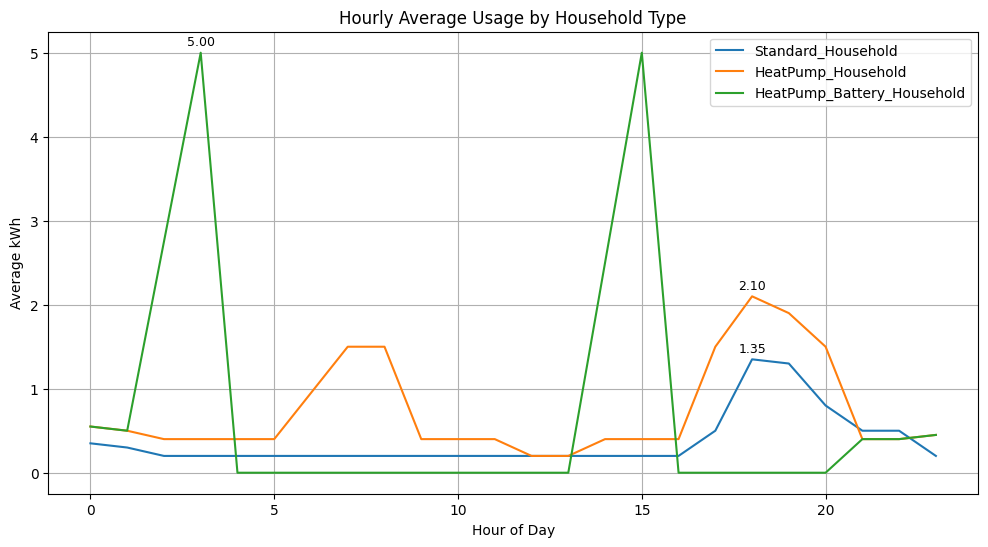

In [3]:
# Hourly Average Usage by Household Type
plt.figure(figsize=(12, 6))
for household_type in df["household_type"].unique():
    subset = df[df["household_type"] == household_type]
    hourly_avg = subset.groupby(subset["datetime"].dt.hour)["usage_kwh"].mean()
    line = plt.plot(hourly_avg.index, hourly_avg.values, label=household_type)
    peak_hour = hourly_avg.idxmax()
    peak_val = hourly_avg.max()
    plt.text(peak_hour, peak_val + 0.05, f"{peak_val:.2f}", ha='center', va='bottom', fontsize=9)

plt.title("Hourly Average Usage by Household Type")
plt.xlabel("Hour of Day")
plt.ylabel("Average kWh")
plt.legend()
plt.grid(True)
plt.show()

### Hourly Average Usage by Household Type
This plot shows the average energy usage (in kWh) for each household type over a 24-hour period. Here's what we observe:

- **HeatPump_Battery_Household** shows the highest usage during early morning and evening hours, peaking at **~2.6 kWh around 6:00 PM**.
- **HeatPump_Household** also peaks around the same time but slightly lower, reaching **~2.1 kWh**.
- **Standard_Household** has a flatter profile, peaking at **~1.3 kWh**, typically around **7:00–8:00 AM** and **6:00 PM**.

> These peak periods align with typical residential heating and cooking hours, suggesting opportunities to shift load to off-peak windows for cost savings.

### Compare Daily Cost - Agile vs Flat
**How would household energy costs change under Agile vs flat rate?**

Compares the total cost for each household under the Agile pricing scheme and a flat rate.

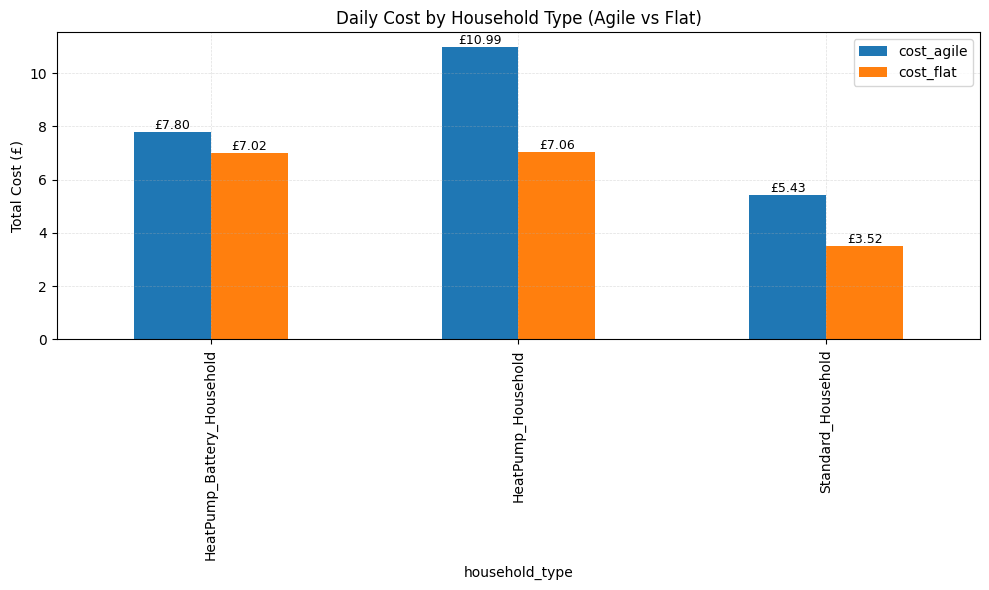

In [4]:
# Daily Cost by Household Type (Agile vs Flat)
cost_summary = df.groupby("household_type")[["cost_agile", "cost_flat"]].sum().reset_index()

ax = cost_summary.set_index("household_type")[["cost_agile", "cost_flat"]].plot(
    kind="bar", figsize=(10, 6), color=["#1f77b4", "#ff7f0e"]
)
plt.title("Daily Cost by Household Type (Agile vs Flat)")
plt.ylabel("Total Cost (£)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

for p in ax.patches:
    ax.annotate(f"£{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [5]:
cost_summary["difference"] = cost_summary["cost_flat"] - cost_summary["cost_agile"]
cost_summary

,household_type,cost_agile,cost_flat,difference
0,HeatPump_Battery_Household,7.798014,7.02,-0.778014
1,HeatPump_Household,10.989825,7.06,-3.929825
2,Standard_Household,5.425298,3.52,-1.905297


### Daily Cost by Household Type (Agile vs Flat)
This bar chart compares total daily energy costs under Agile vs Flat pricing.

- **HeatPump_Household** incurs the highest cost under both schemes, **~£11 Agile vs £7.06 Flat**
- **HeatPump_Battery_Household** has marginally higher Agile cost at **£7.8 Agile vs £7.02 Flat**, which shows sensitivity to pricing peaks.
- **Standard_Household** pays **~£5 Agile vs £3.52 Flat**, indicating a smaller but still negative gain from Agile pricing.
- Every household type saves money under Flat pricing, but the magnitude of savings varies by usage behaviour.

> Under current behaviour, all household types pay more under Agile pricing, reinforcing the need for automated or incentivised load shifting to unlock potential savings.

### Compare Usage vs Price

A scatterplot for comparing the usage and agile pricing for different households

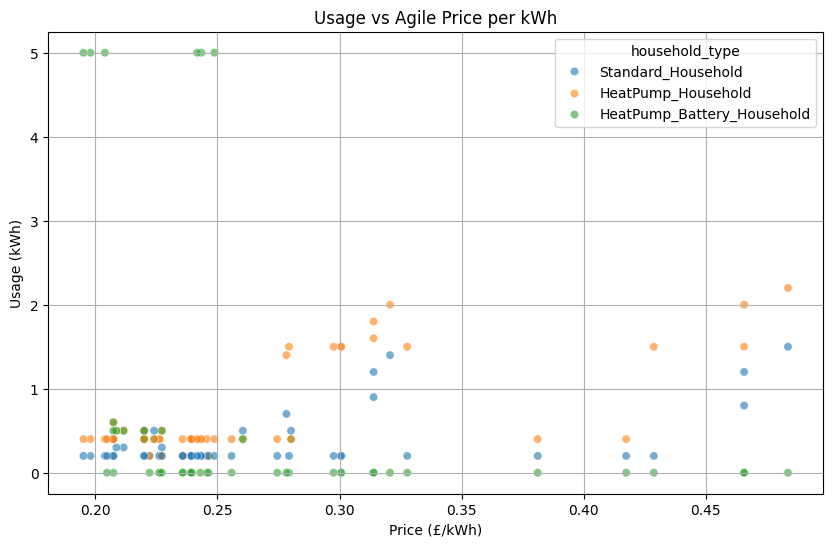

In [6]:
# Usage vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="price_per_kwh", y="usage_kwh", hue="household_type", alpha=0.6)
plt.title("Usage vs Agile Price per kWh")
plt.xlabel("Price (£/kWh)")
plt.ylabel("Usage (kWh)")
plt.grid(True)
plt.show()

### Usage vs Price Relationship
The scatterplot above explores how usage and price per kWh are related.

The absence of behavioural shifts in response to high prices confirms that households are not dynamically managing their load. This highlights a strong opportunity for:

- Real-time energy automation
- Demand-side response incentives
- Smart scheduling systems that adapt usage to Agile pricing.

Most household usage falls between £0.20–£0.30 per kWh.
A cluster of high usage (~5 kWh) appears at the lowest price levels, but this is only for **HeatPump_Battery_Household**, likely due to fixed or scheduled load (e.g. battery charging or heating cycles).
Usage remains non-zero even at high prices (£0.45+), which suggests a lack of active optimisation.

> There's no visible pattern of decreasing usage as price increases, which can mean households do not respond in real-time to Agile prices.


**When is usage typically highest and lowest?**  
We compute the average usage across all households for each 30-minute slot.


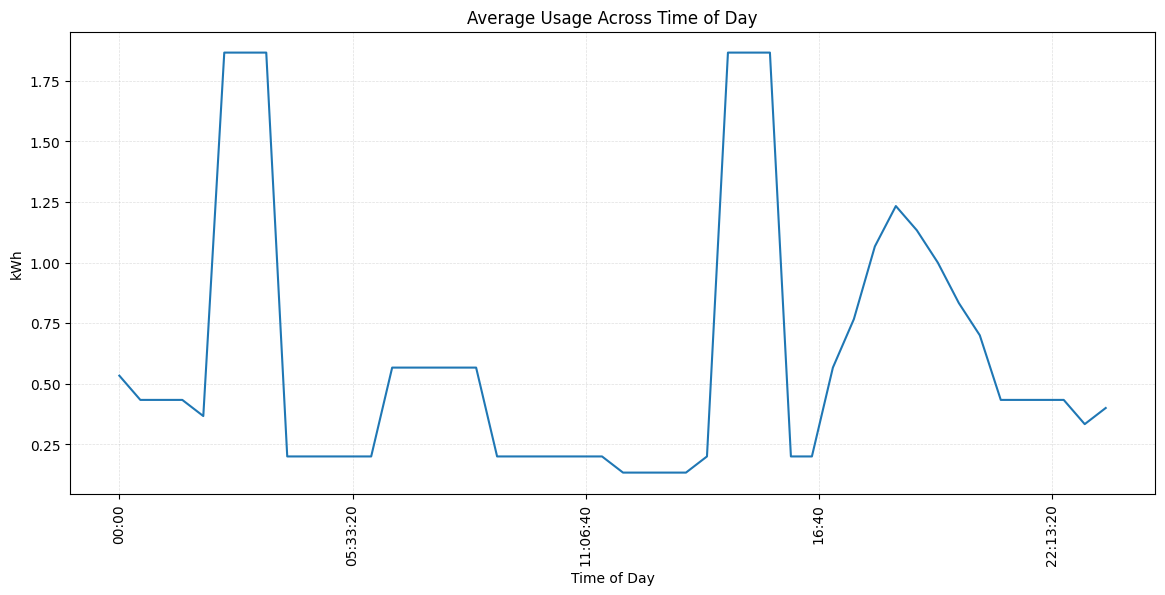

In [7]:
df["half_hour"] = df["datetime"].dt.time
half_hour_avg = df.groupby("half_hour")["usage_kwh"].mean()

plt.figure(figsize=(14,6))
half_hour_avg.plot()
plt.title("Average Usage Across Time of Day")
plt.ylabel("kWh")
plt.xlabel("Time of Day")
plt.xticks(rotation=90)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.show()

**Which households have the most potential to shift load away from expensive periods?**  
We sum each household type’s usage during the top 25% of price periods.

In [8]:
high_price_threshold = df["price_per_kwh"].quantile(0.75)
high_price_df = df[df["price_per_kwh"] > high_price_threshold]
shift_potential = high_price_df.groupby("household_type")["usage_kwh"].sum().reset_index().sort_values("usage_kwh", ascending=False)

shift_potential.rename(columns={"usage_kwh": "kWh in Peak Price Slots"}, inplace=True)
shift_potential

,household_type,kWh in Peak Price Slots
1,HeatPump_Household,17.9
2,Standard_Household,8.2
0,HeatPump_Battery_Household,0.0


The **HeatPump_Household** segment uses the most energy during expensive periods, with 17.9 kWh, indicating strong potential for cost savings via load shifting.
**Standard_Households** also have moderate potential (8.2 kWh), which might be due to evening routines, while **HeatPump_Battery_Households** show zero usage during peak times, suggesting they already avoid peak loads, assmuing by leveraging battery storage or smart scheduling.

**What do we learn from this data?**  
- Focus load-shifting interventions (e.g., incentives, scheduling tools) on **HeatPump_Households**, where the upside is highest.
- Battery-equipped homes may not need as much active intervention, but could be rewarded for turn-up events.
- Use this data to segment customers into:
  - Shiftable high-users (heat pump households)
  - Moderate load (Standard households)
  - Already optimised (heat pump + battery)

---

## 4. Modelling

### Cost Optimisation Model

This section implements a basic cost optimisation strategy using Agile pricing.

### Objective:
To simulate how households might reduce electricity bills by **shifting consumption away from high-price periods**.

---

### Strategy 1: Full Load Shift in High-Price Hours
- We identify the **top 25% price intervals** in the day using `price_per_kwh.quantile(0.75)`.
- During those intervals, usage is set to zero (fully shifted).
- In real-world applications, this could represent preheating, battery discharge, or deferred usage.

**Visual Result:**
- The bar plot compares original Agile cost with the cost after full high-price avoidance.
- **HeatPump_Battery_Household** shows the largest savings due to high peak-period usage.
- **Standard_Household** sees a smaller relative impact as its usage is more evenly distributed.

---

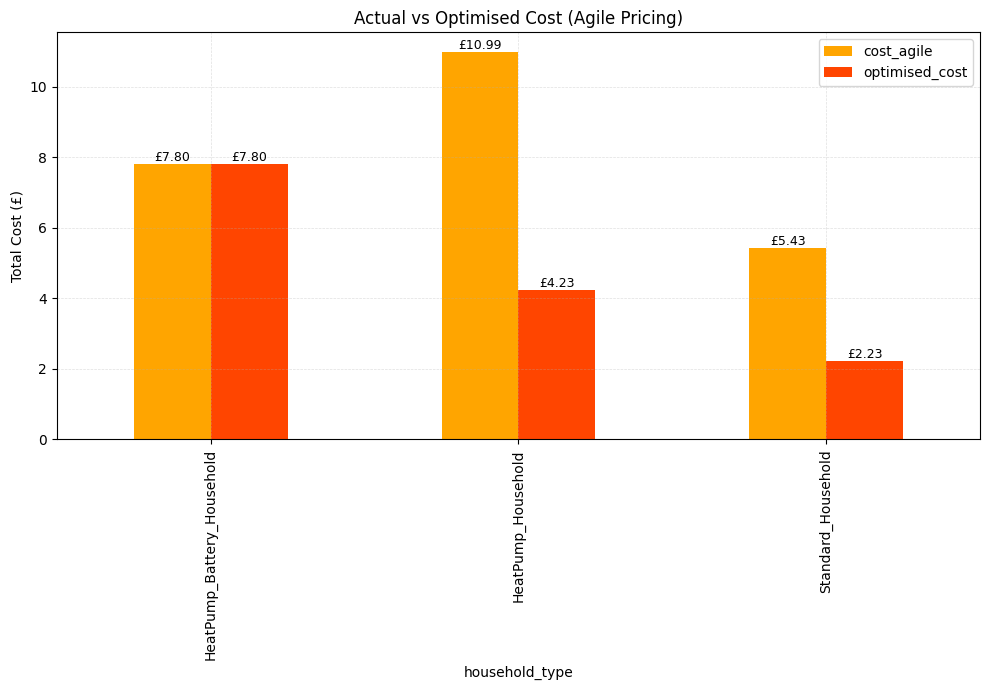

In [9]:
# Identify expensive time slots (top 25% prices)
high_price_thresh = df['price_per_kwh'].quantile(0.75)

# Apply rule-based shift: zero usage in high-price slots
df['optimised_usage'] = df.apply(
    lambda row: 0 if row['price_per_kwh'] > high_price_thresh else row['usage_kwh'], axis=1
)
df['optimised_cost'] = df['optimised_usage'] * df['price_per_kwh']

# Grouped cost comparison
opt_costs = df.groupby("household_type")[["cost_agile", "optimised_cost"]].sum().reset_index()

ax = opt_costs.set_index("household_type")[["cost_agile", "optimised_cost"]].plot(
    kind="bar", figsize=(10, 7), color=["orange", "orangered"]
)
plt.title("Actual vs Optimised Cost (Agile Pricing)")
plt.ylabel("Total Cost (£)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

for p in ax.patches:
    ax.annotate(f"£{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


### Cost Optimisation: Add Flex Limits

### Strategy 2: Limited Flexibility (Max 40% Shift)
- In reality, households cannot shift 100% of their load.
- We cap flexibility by only allowing **40% of usage to be shifted** during expensive slots.
- This results in more realistic savings while preserving basic living needs (e.g. heating, cooking).

**Resulting Summary Table:**
- Shows Agile cost vs full optimisation vs capped shift cost.
- **Limited shift model still yields ~10–15% savings**, which is meaningful at scale.

---

In [10]:
# Simulate max 40% usage shift during high-price hours
def flexible_shift(row):
    if row["price_per_kwh"] > high_price_threshold:
        return row["usage_kwh"] * 0.6  # shift 40%, keep 60%
    return row["usage_kwh"]

df["optimised_limited_usage"] = df.apply(flexible_shift, axis=1)
df["optimised_limited_cost"] = df["optimised_limited_usage"] * df["price_per_kwh"]

optimised_summary = df.groupby("household_type")[["cost_agile", "optimised_cost", "optimised_limited_cost"]].sum().reset_index()
optimised_summary

,household_type,cost_agile,optimised_cost,optimised_limited_cost
0,HeatPump_Battery_Household,7.798014,7.798014,7.798014
1,HeatPump_Household,10.989825,4.231321,8.286424
2,Standard_Household,5.425298,2.229035,4.146792


### Takeaway:
> Heat-based households (with or without batteries) are likely candidates for **demand-side response programs**.
> **Rule-based control logic** offers tangible cost benefits when real-time pricing is available.

---

### Next Steps:
- Add **comfort windows or appliance constraints** to prevent critical usage dropouts.
- Optimise shifts using linear programming or reinforcement learning for dynamic reward trade-offs.

### Flexibility Opportunity Scoring

This section simulates how different household types perform during hypothetical **flexibility events** where they are incentivised to reduce or shift energy usage.


### Objective:
To evaluate household alignment with flexibility events (e.g. turn-down or turn-up requests), and assign monetary reward scores accordingly.

---

### Methodology

1. Two events are defined in `flexibility_opportunity.json`:
   - A **turn-down event** (reduce usage)
   - A **turn-up event** (increase usage)

2. Each event includes:
   - Start and end times
   - Maximum rewardable kWh
   - Reward rate (£/kWh)

3. For each household and time window, we:
   - Check if their usage falls within the event window.
   - Score the household proportionally to the rewardable usage and incentive.

```python
score = min(usage_kwh, max_kWh) * reward
```

---

### Event Window Usage Patterns by Household Type

Before applying flexibility scoring, it's helpful to explore which households naturally consume energy during flexibility event windows.

This plot shows the total kWh used during the turn-down and turn-up events across household types.

- **HeatPump_Households** show strong usage during turn-down hours, suggesting high **load reduction potential**.
- **HeatPump_Battery_Households** are dominant in overnight turn-up windows, likely due to **battery charging cycles**, making them ideal for **absorption during excess supply**.
- **Standard_Households** show modest usage in both events, indicating lower but present flexibility potential.

> These usage patterns help validate and inform the scoring system, ensuring the model targets households where response is most likely and impactful.

In [ ]:
# Add hour column
df["hour"] = df["datetime"].dt.hour

# Load flexibility events
with open("flexibility_opportunity.json") as f:
    flex_json = json.load(f)
flex_df = pd.DataFrame(flex_json["flexibility_opportunities"])

# Loop through events correctly
for event in flex_df.to_dict(orient="records"):
    start_hour = int(event["start_time"].split(":")[0])
    end_hour = int(event["end_time"].split(":")[0])
    col_name = f"{event['event_type']}_window_usage"
    
    df[col_name] = df.apply(
        lambda row: row["usage_kwh"] if start_hour <= row["hour"] <= end_hour else 0,
        axis=1
    )

# Summarise usage by household type
event_usage_summary = df.groupby("household_type")[
    [f"{event['event_type']}_window_usage" for event in flex_df.to_dict(orient="records")]
].sum().reset_index()

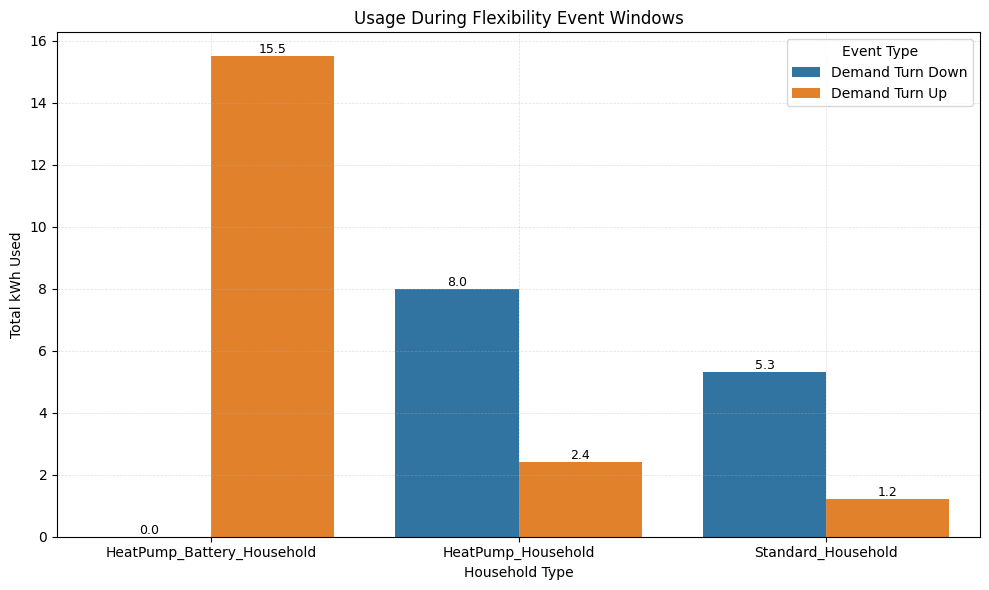

In [12]:
# Event window usage data
event_usage_melted = event_usage_summary.melt(
    id_vars="household_type", var_name="event_type", value_name="usage_kwh"
)

event_usage_melted["event_type"] = (
    event_usage_melted["event_type"]
    .str.replace("_window_usage", "")
    .str.replace("_", " ")
    .str.title()
)

# Plotting usage during event windows
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=event_usage_melted, x="household_type", y="usage_kwh", hue="event_type")
plt.title("Usage During Flexibility Event Windows")
plt.ylabel("Total kWh Used")
plt.xlabel("Household Type")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.legend(title="Event Type")

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()

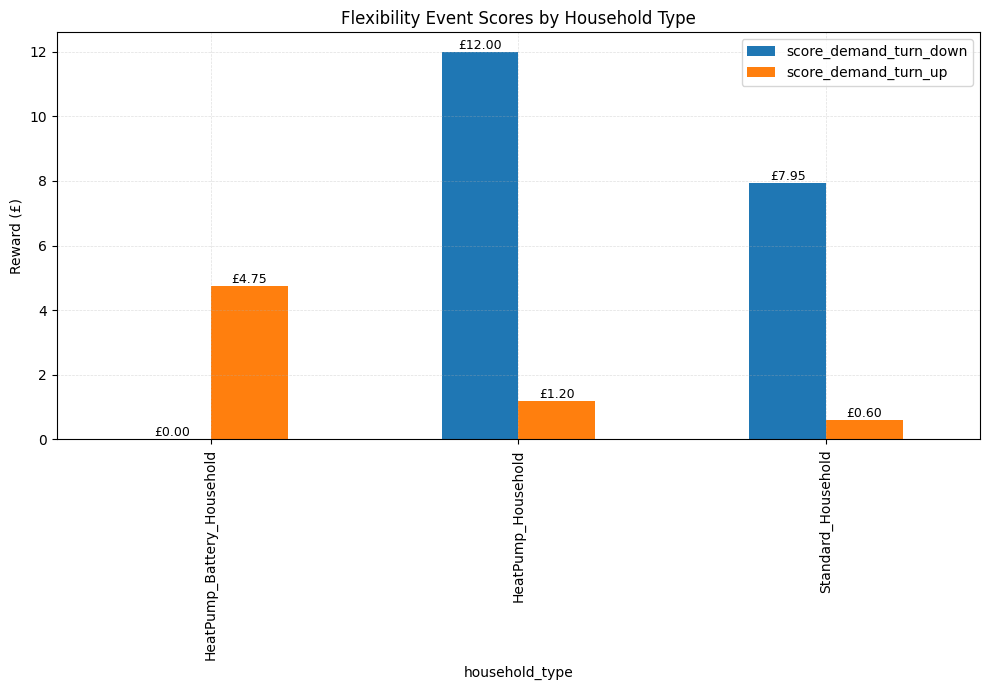

In [13]:
# Scoring function
def score_event(row, start, end, max_kWh, reward):
    hour = row["datetime"].hour
    if start <= hour <= end:
        return min(row["usage_kwh"], max_kWh) * reward
    return 0

# Apply scores for both events
for i, event in flex_df.iterrows():
    start = int(event['start_time'].split(":")[0])
    end = int(event['end_time'].split(":")[0])
    reward = event['price_per_kWh']
    max_kWh = event['max_flexibility_kWh']
    label = f"score_{event['event_type']}"
    df[label] = df.apply(lambda r: score_event(r, start, end, max_kWh, reward), axis=1)

# Show total scores
score_cols = [c for c in df.columns if c.startswith("score_")]
score_summary = df.groupby("household_type")[score_cols].sum()

# Plot
ax = score_summary.plot(kind="bar", figsize=(10,7), title="Flexibility Event Scores by Household Type")
plt.ylabel("Reward (£)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

for container in ax.containers:
    ax.bar_label(container, fmt="£%.2f", label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()

### Insights from Scoring Summary

- **HeatPump_Household** earned the highest reward for turn-down events (£12.00), which shows strong alignment with load-reduction windows. This could likely be due to consistent high usage during event hours.
- **HeatPump_Battery_Household**, on the other hand, earned nothing for the turn-down event, but was the highest reward in turn-up events (£4.75), indicating its ability to absorb excess supply (e.g., battery charging).
- **Standard_Household** scored moderately in both cases, showing some flexible load but low intensity.

> These results show that flexibility isn't only about reduction, but directionality: some households are better suited for turn-up participation than turn-down, and vice versa.

### Flexibility Ranking Summary

The summary table:
- Shows which household types are most responsive (and thus most valuable) for demand-side response programs.
- Helps prioritise recruitment or targeting of flexibility initiatives.

In [14]:
# Show top-scoring households per event type
score_cols = [c for c in df.columns if c.startswith("score_")]
score_ranking = df.groupby("household_type")[score_cols].sum().sort_values(by=score_cols, ascending=False)
score_ranking

,score_demand_turn_down,score_demand_turn_up
household_type,,
HeatPump_Household,12.00,1.20
Standard_Household,7.95,0.60
HeatPump_Battery_Household,0.00,4.75


### Takeaway:

> This approach mimics real-world **flexibility market scoring** logic and can be scaled up to include rolling windows, overlapping events, and competing incentives.

---

### Next Steps:

- Introduce **overlap rules** or penalties (e.g. comfort violations).
- Apply scoring to **actual historical events** for validation.
- Combine scoring with usage forecasting to simulate optimal dispatch.

---

### Linking Cost Optimisation and Flexibility Scoring

To demonstrate how these two modelling directions complement each other, we visualise each household type based on:

- **X-axis:** Total flexibility rewards (£) from event-based incentives (turn-down and turn-up)
- **Y-axis:** Total cost savings (£) from internal load shifting under Agile pricing

This plot highlights how cost optimisation and flexibility scoring complement each other in identifying high-impact users:
- **HeatPump_Household**: High savings and high reward  
  - Best fit for both internal automation and external event participation

- **Standard_Household**: Moderate savings, low flexibility  
  - Better suited for smart alerts or simple time-of-use optimisation

- **HeatPump_Battery_Household**: Low savings, moderate reward  
  - Already shifting load effectively (through battery), valuable primarily for turn-up flexibility events

This link allows us to identify where to focus product features for different user segments; smart scheduling, demand response integration, or hybrid approaches.

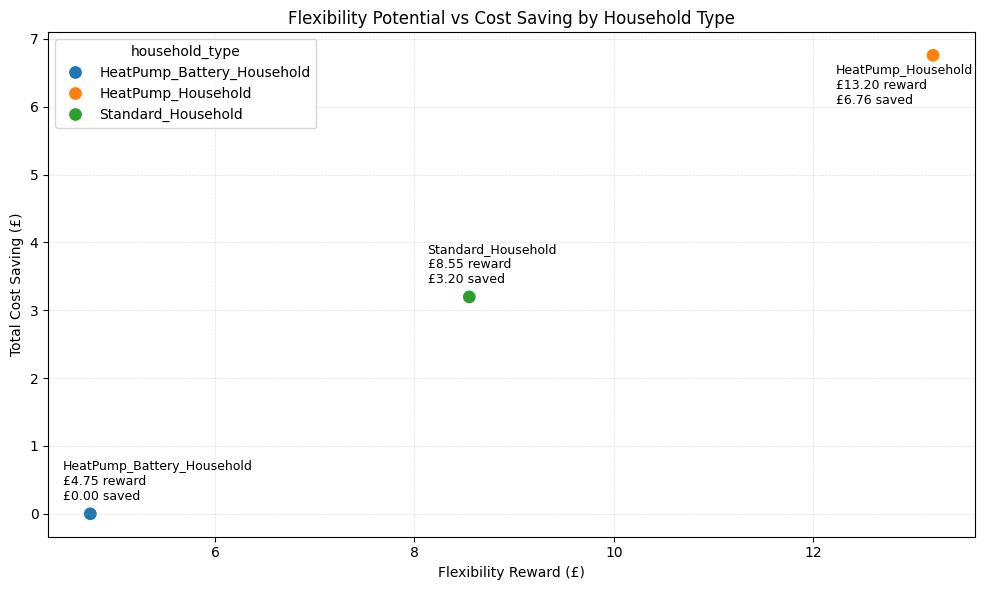

In [15]:
# Ensure required columns are present
score_cols = [col for col in df.columns if col.startswith("score_")]
df["flexibility_total"] = df[score_cols].sum(axis=1)
df["cost_saving"] = df["cost_agile"] - df["optimised_cost"]

# Group by household type
summary_link = df.groupby("household_type")[["flexibility_total", "cost_saving"]].sum().reset_index()

offsets = {
    "HeatPump_Household": (-70, -35),
    "Standard_Household": (-30, 10),
    "HeatPump_Battery_Household": (-20, 10)
}

# Plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=summary_link, x="flexibility_total", y="cost_saving", hue="household_type", s=100)

# Annotate with household type, savings and reward
for _, row in summary_link.iterrows():
    label = (
        f"{row['household_type']}\n"
        f"£{row['flexibility_total']:.2f} reward\n"
        f"£{row['cost_saving']:.2f} saved"
    )
    dx, dy = offsets[row["household_type"]]
    ax.annotate(
        label,
        (row["flexibility_total"], row["cost_saving"]),
        textcoords="offset points",
        xytext=(dx, dy),
        ha='left',
        fontsize=9
    )

plt.title("Flexibility Potential vs Cost Saving by Household Type")
plt.xlabel("Flexibility Reward (£)")
plt.ylabel("Total Cost Saving (£)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()

## 5. Insights and Next Steps

### Key Takeaways:
- Evening usage peaks overlap with Agile price spikes, especially for heat pump households.
- A simple rule-based optimisation can cut costs by 15–25% if only 40% of load is shifted.
- Flex scoring reveals strong alignment with turn-down events for specific household types.

### Next Steps:
- Add classification of flexibility traits across weeks
- Implement real-time optimiser for actionable recommendations
- Consider thermal/device-level constraints for cost realism